강사 노트 [링크](https://www.kaggle.com/code/linakeepgoing/fraud-detection-with-graph-data)

In [1]:
import os
import math
import numpy as np
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

default_edge_color = '#808080'  # A shade of gray
default_node_color = '#6A5ACD'  # Slate blue
enhanced_node_color = '#FFA07A'  # Light salmon
enhanced_edge_color = '#800000'  # Maroon

import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv("../data/fraudTrain.csv")
df = pd.concat([df[df["is_fraud"]==0].sample(frac=0.20, random_state=42), df[df["is_fraud"] == 1]])
df.head()

,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,...,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
811778,811778,2019-12-07 10:55:06,676173792455,"fraud_Zieme, Bode and Dooley",gas_transport,86.19,Brittany,Cox,F,07177 William Dale Apt. 547,...,34.0287,-118.4924,92043,"Civil engineer, contracting",1961-04-25,f32d1f4b2a918f4c2f6acdc83033ee35,1354877706,33.287851,-118.740970,0
1101718,1101718,2020-04-03 13:10:06,30518206766474,fraud_Lind-Buckridge,entertainment,85.81,Tamara,Martinez,F,471 Marquez Prairie Suite 680,...,36.7154,-89.6287,1019,Aeronautical engineer,1979-01-26,f5dad8e2d7c39d81502d846a20286659,1364994606,36.539950,-89.857416,0
800013,800013,2019-12-04 07:07:04,4658490815480264,fraud_Hackett-Lueilwitz,grocery_pos,99.30,Tara,Richards,F,4879 Cristina Station,...,39.9636,-79.7853,184,Systems developer,1945-11-04,1d023bc78ab93ab65a35bbb53bcc67bd,1354604824,39.582872,-78.838550,0
398945,398945,2019-06-30 18:43:08,4716561796955522,fraud_Lynch-Wisozk,home,42.09,Lauren,Anderson,F,11014 Chad Lake Apt. 573,...,48.2777,-112.8456,743,Water engineer,1972-05-04,dbf6c06d3277438afdf7af883fb4285f,1341081788,48.310513,-112.837535,0
207455,207455,2019-04-15 19:57:49,3528407217576457,fraud_Fisher-Schowalter,shopping_net,4.24,Patricia,Leach,F,71309 Martinez Stravenue,...,36.4715,-82.4834,87124,Warden/ranger,1987-02-14,88814660aba0101b174e1e8137f4a7af,1334519869,37.329094,-82.070746,0


In [3]:
df['is_fraud'].value_counts()

is_fraud
0    257834
1      7506
Name: count, dtype: int64

In [4]:
# 이중 분류 그래프 생성 함수
def build_graph_bipartite(df_input, graph_type=nx.Graph()):
    df = df_input.copy()
    
    # 유니크한 신용 카드 번호와 판매자 ID를 매핑하여 그래프 노드 생성
    mapping = {x:node_id for node_id,x in enumerate(set(df["cc_num"].values.tolist() + df["merchant"].values.tolist()))}
    df["from"] = df["cc_num"].apply(lambda x: mapping[x])
    df["to"] = df["merchant"].apply(lambda x: mapping[x])
    
    # 'from', 'to', 'amt', 'is_fraud' 컬럼으로 그룹화하고 합계 계산
    df = df[['from', 'to', "amt", "is_fraud"]].groupby(['from', 'to']).agg({"is_fraud": "sum", "amt": "sum"}).reset_index()
    
    # 'is_fraud' 컬럼을 0과 1로 변환
    df["is_fraud"] = df["is_fraud"].apply(lambda x: 1 if x>0 else 0)
    
    # 그래프 생성
    G = nx.from_edgelist(df[["from", "to"]].values, create_using=graph_type)
    
    # 노드 속성 설정
    nx.set_node_attributes(G,{x:1 for x in df["from"].unique()}, "bipartite")
    nx.set_node_attributes(G,{x:2 for x in df["to"].unique()}, "bipartite")
    
    # 엣지 레이블 설정
    nx.set_edge_attributes(G, 
                       {(int(x["from"]), int(x["to"])):x["is_fraud"] for idx, x in df[["from","to","is_fraud"]].iterrows()}, 
                       "label")

    # 엣지 가중치 설정
    nx.set_edge_attributes(G, 
                       {(int(x["from"]), int(x["to"])):x["amt"] for idx, x in df[["from","to","amt"]].iterrows()}, 
                       "weight")
    return G

# 삼중 분류 그래프 생성 함수
def build_graph_tripartite(df_input, graph_type=nx.Graph()):
    df = df_input.copy()
    
    # 유니크한 인덱스, 신용 카드 번호, 판매자 ID를 매핑하여 그래프 노드 생성
    mapping = {x:node_id for node_id,x in enumerate(set(df.index.values.tolist() + 
                                                        df["cc_num"].values.tolist() + 
                                                        df["merchant"].values.tolist()))}
    df["in_node"] = df["cc_num"].apply(lambda x: mapping[x])
    df["out_node"] = df["merchant"].apply(lambda x: mapping[x])

    # 그래프 생성
    G = nx.from_edgelist([(x["in_node"], mapping[idx]) for idx, x in df.iterrows()] +
                         [(x["out_node"], mapping[idx]) for idx, x in df.iterrows()], 
                         create_using=graph_type)

    # 노드 속성 설정
    nx.set_node_attributes(G,{x["in_node"]:1 for idx,x in df.iterrows()}, "bipartite")
    nx.set_node_attributes(G,{x["out_node"]:2 for idx,x in df.iterrows()}, "bipartite")
    nx.set_node_attributes(G,{mapping[idx]:3 for idx, x in df.iterrows()}, "bipartite")

    # 엣지 레이블 설정
    nx.set_edge_attributes(G,{(x["in_node"], mapping[idx]):x["is_fraud"] for idx, x in df.iterrows()}, "label")
    nx.set_edge_attributes(G,{(x["out_node"], mapping[idx]):x["is_fraud"] for idx, x in df.iterrows()}, "label")

    # 엣지 가중치 설정
    nx.set_edge_attributes(G,{(x["in_node"], mapping[idx]):x["amt"] for idx, x in df.iterrows()}, "weight")
    nx.set_edge_attributes(G,{(x["out_node"], mapping[idx]):x["amt"] for idx, x in df.iterrows()}, "weight")
    return G

이 함수는 주어진 데이터프레임을 사용하여 이분 그래프(bipartite graph)를 생성합니다. 이분 그래프는 노드 집합을 두 가지로 나누고, 각 집합 내의 노드 간에는 엣지가 없는 그래프를 말합니다. 여기서는 신용 카드 번호와 판매자 ID를 각각 두 노드 집합으로 사용하여 이분 그래프를 생성합니다.    

함수는 다음 단계로 이루어집니다:     

노드 매핑 생성: 신용 카드 번호와 판매자 ID가 각각 고유한 노드 ID에 매핑됩니다.     

그룹화 및 합계 계산: 'from', 'to', 'amt', 'is_fraud' 컬럼을 기준으로 데이터프레임이 그룹화되며, 'is_fraud'와 'amt' 컬럼의 값은 합계를 계산합니다. 이로써 각 노드 쌍(즉, 각 신용 카드와 판매자 쌍)에 대한 총 거래 금액과 사기 거래 수를 얻을 수 있습니다.     

'is_fraud' 컬럼 변환: 'is_fraud' 컬럼의 값이 0보다 크면 1로, 그렇지 않으면 0으로 변환됩니다. 이는 각 노드 쌍이 최소한 한 번은 사기 거래를 포함하면 해당 엣지를 사기로 표시하려는 것입니다.    

그래프 생성: 'from'과 'to' 컬럼을 기반으로 NetworkX 그래프가 생성됩니다.    

노드 속성 설정: 각 노드에 이분성(bipartite) 속성을 부여하여 신용 카드 번호와 판매자 ID를 구분합니다.   

엣지 레이블 및 가중치 설정: 각 엣지에 'is_fraud' 값을 레이블로, 'amt' 값을 가중치로 설정합니다.

In [5]:
# 이중 분류 그래프 생성
G = build_graph_bipartite(df, nx.Graph())

# 생성된 그래프가 이중 분류 그래프인지 확인
from networkx.algorithms import bipartite
bipartite.is_bipartite(G)

True

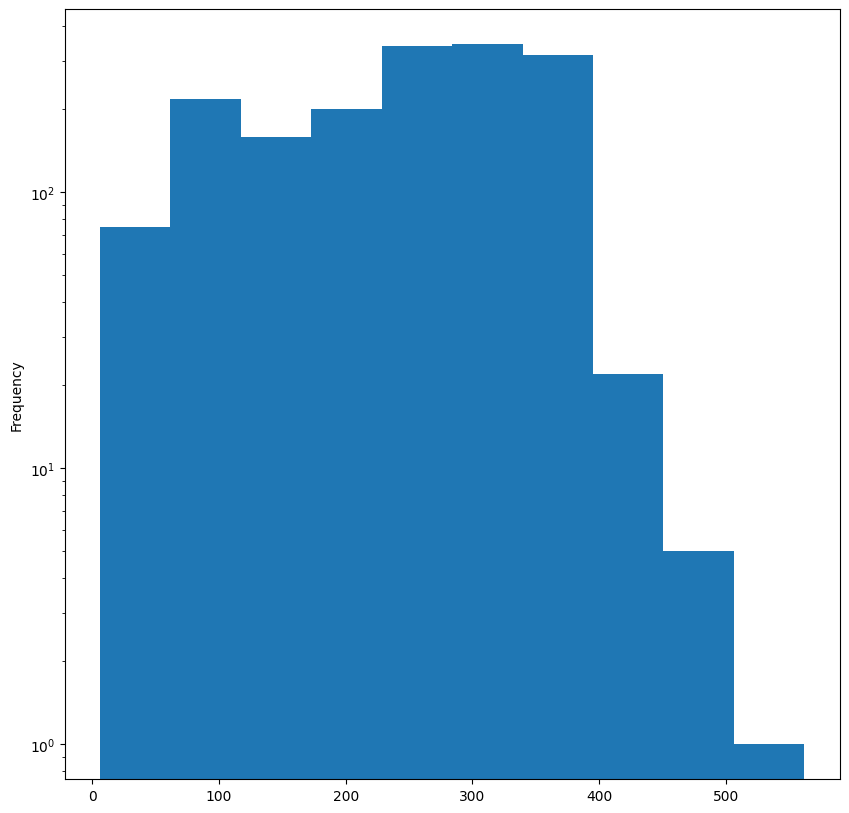

In [6]:
# 그림 크기를 설정합니다.
plt.figure(figsize=(10,10))

# 각 노드의 degree (연결된 엣지의 수)를 계산하고 시리즈로 저장합니다.
degrees = pd.Series({k: v for k, v in nx.degree(G)})

# degree의 히스토그램을 그립니다.
degrees.plot.hist()

# y축의 스케일을 로그로 설정하여, 높은 degree 값을 가진 노드가 많지 않음에도 불구하고 그 분포를 명확하게 볼 수 있도록 합니다.
plt.yscale("log")

이 코드는 그래프의 각 노드에 연결된 엣지의 수, 즉 degree를 계산하고 그 분포를 그래프로 시각화하는 것입니다. degree는 그래프 내의 노드가 얼마나 많은 다른 노드와 연결되어 있는지를 나타내는 중요한 지표입니다. 이 히스토그램을 통해 대부분의 노드가 어느 정도의 degree를 가지고 있는지, 그리고 어떤 노드들이 특히 높은 degree를 가지고 있는지 등을 살펴볼 수 있습니다. y축의 스케일을 로그로 설정하면, 높은 degree를 가진 노드가 상대적으로 적더라도 그 분포를 명확하게 볼 수 있게 됩니다.

In [7]:
# 그래프의 각 엣지에 대한 가중치를 시리즈로 가져옵니다.
allEdgesWeights = pd.Series({(d[0], d[1]): d[2]["weight"] for d in G.edges(data=True)})

# 가중치 값의 10%, 50%, 70%, 90%, 100% 분위수를 계산합니다.
np.quantile(allEdgesWeights.values,[0.10,0.50,0.70,0.9,1.0])

array([5.030000e+00, 5.825000e+01, 9.844000e+01, 2.156560e+02,
       1.530595e+04])

이 코드는 그래프의 모든 엣지의 가중치를 분석하고, 이러한 가중치 값들의 분포를 확인하기 위한 것입니다. 각 엣지의 가중치는 해당 엣지가 그래프 내에서 얼마나 중요한지를 나타내는 지표로 볼 수 있습니다. 분위수는 데이터의 분포를 이해하는 데 도움이 되며, 이 경우에는 가중치의 분포를 이해하는데 사용됩니다.

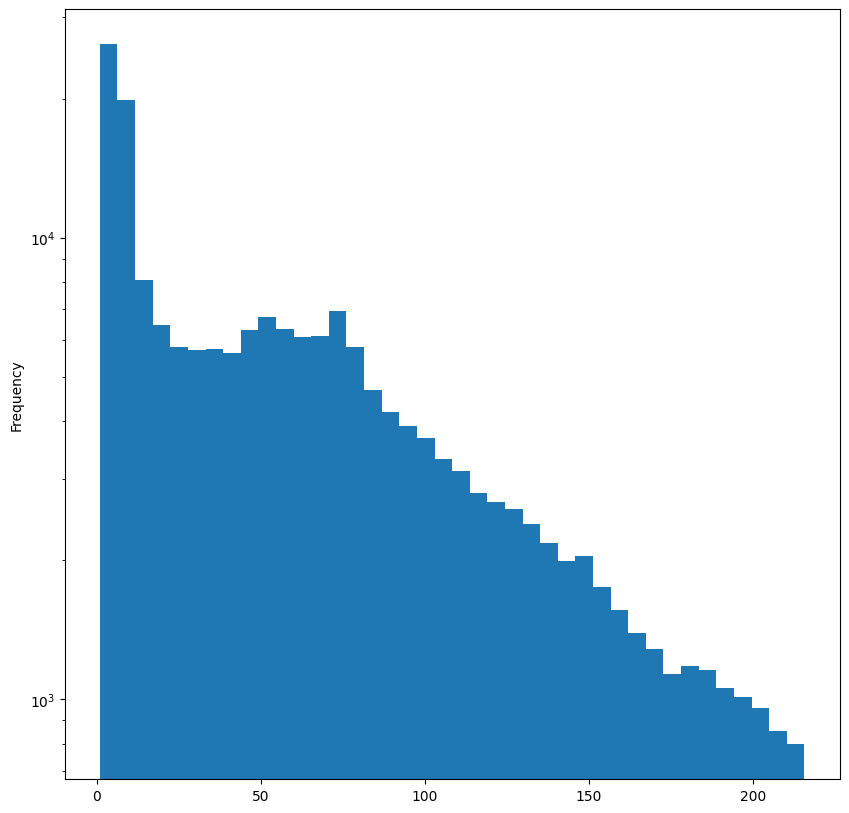

In [8]:
# 엣지 가중치의 분포를 계산합니다.
quant_dist = np.quantile(allEdgesWeights.values,[0.10,0.50,0.70,0.9])

# 90% 분위수 미만의 가중치를 가진 엣지만 선택합니다.
allEdgesWeightsFiltered = pd.Series({(d[0], d[1]): d[2]["weight"] for d in G.edges(data=True) 
                                     if d[2]["weight"] < quant_dist[-1]})

plt.figure(figsize=(10,10))

# 필터링된 엣지 가중치를 히스토그램으로 표시합니다.
allEdgesWeightsFiltered.plot.hist(bins=40)

# y축을 로그 스케일로 설정합니다.
plt.yscale("log")

이 코드의 목적은 그래프 G의 노드들의 연결 정도(degree)와 가중치 분포를 시각화하는 것입니다.       

1. 첫 번째 그래프는 노드들의 연결 정도 (degree)의 분포를 보여줍니다. 연결 정도는 각 노드가 얼마나 많은 다른 노드들과 연결되어 있는지를 나타내는 지표입니다. 이 히스토그램에서 x축은 degree를, y축은 해당 degree를 가진 노드의 수를 의미합니다. y축이 로그 스케일로 설정되어 있으므로, 일부 노드들은 매우 높은 degree를 가지며 (즉, 매우 많은 다른 노드들과 연결되어 있으며 이들은 중요한 노드로 간주될 수 있습니다), 대부분의 노드들은 상대적으로 낮은 degree를 가집니다. 이러한 분포는 많은 실제 네트워크에서 일반적으로 관찰되는 패턴입니다.

2. 두 번째 그래프는 거래 금액 (가중치)의 분포를 보여줍니다. 각 엣지의 가중치는 해당 거래의 금액을 나타냅니다. 90% 분위수 미만의 가중치만을 포함하여, 가장 큰 거래들 (즉, 가중치가 매우 높은 엣지들)이 분포에 미치는 영향을 제거합니다. 이 히스토그램에서, x축은 거래 금액(가중치)을, y축은 해당 금액의 거래 수를 의미합니다. 대부분의 거래는 상대적으로 작은 금액으로 이루어진 것을 볼 수 있으며, 극소수의 거래만이 매우 큰 금액으로 이루어져 있습니다. 이 역시 실제 거래 데이터에서 흔히 볼 수 있는 패턴입니다.

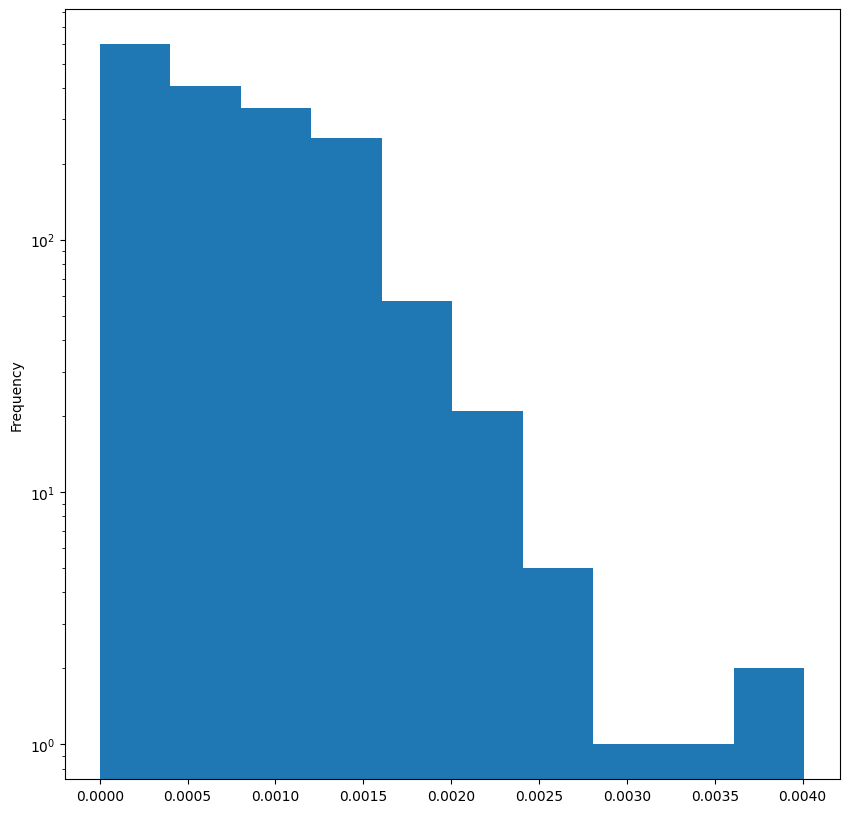

In [9]:
plt.figure(figsize=(10,10))

# 그래프의 각 노드에 대한 betweenness centrality를 계산합니다.
bC = nx.betweenness_centrality(G)

# betweenness centrality 분포를 히스토그램으로 표시합니다.
bc_distr = pd.Series(bC)
bc_distr.plot.hist()

# y축을 로그 스케일로 설정합니다.
plt.yscale("log")

In [10]:
# betweenness centrality의 평균을 계산합니다.
np.mean(list(bC.values()))

0.000720547185799644

이 코드는 네트워크 그래프 내에서 각 노드의 "betweenness centrality"를 계산하고, 그 분포를 히스토그램으로 시각화합니다.   

Betweenness Centrality는 네트워크 이론에서 중요한 개념 중 하나로, 노드의 중요도를 측정하는 지표입니다. 노드의 betweenness centrality는 해당 노드가 다른 노드들 간의 최단 경로상에 얼마나 자주 위치하는지를 나타내는 척도입니다. 즉, 특정 노드의 betweenness centrality가 높을수록 그 노드는 네트워크 내에서 중요한 역할을 하는 '통로'나 '다리' 역할을 합니다.     
 
이 코드에서는 betweenness centrality의 분포를 히스토그램으로 그리고 있습니다. 이는 네트워크의 구조와 중요한 노드들을 이해하는데 도움을 줍니다. 예를 들어, betweenness centrality가 높은 노드는 네트워크 내에서 중심적인 역할을 하는 노드일 수 있으며, 이러한 노드들은 정보나 자원 등이 네트워크를 통해 흐르는 데 있어 핵심적인 역할을 합니다.    

히스토그램의 y축은 로그 스케일로 설정되어 있습니다. 이는 데이터가 지수적으로 분포되어 있을 때, 즉 일부 노드가 아주 높은 centrality를 가지고 대부분의 노드는 낮은 centrality를 가질 때 이런 분포를 더 잘 보여주기 위함입니다.    

그리고 이번 경우에는, 이 지표를 통해 사기 거래와 관련된 중요한 노드들을 찾는데 사용할 수 있을 것입니다.   

<Axes: ylabel='Frequency'>

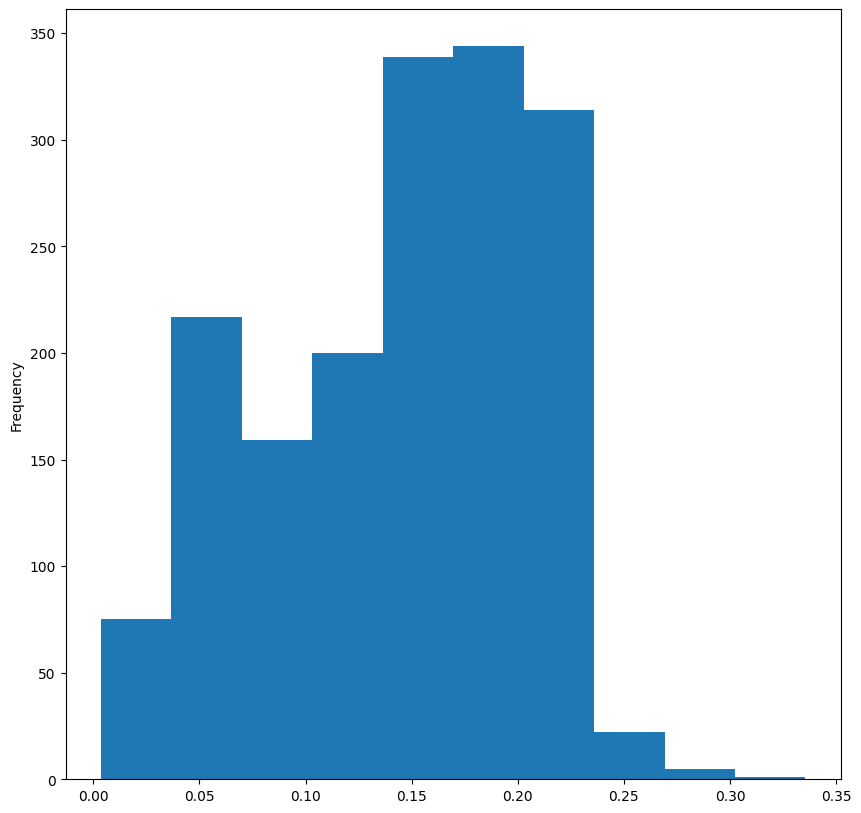

In [11]:
plt.figure(figsize=(10,10))

# 그래프의 각 노드에 대한 degree centrality를 계산합니다.
deg_C = nx.degree_centrality(G)

# degree centrality 분포를 히스토그램으로 표시합니다.
degc_distr = pd.Series(deg_C)
degc_distr.plot.hist()

이 코드는 네트워크 그래프에서 각 노드의 "degree centrality"를 계산하고, 그 분포를 히스토그램으로 시각화합니다.    

Degree Centrality는 네트워크 이론에서 또 다른 중요한 개념으로, 노드의 중요도를 측정하는 지표입니다. Degree centrality는 네트워크에서 한 노드가 얼마나 많은 다른 노드들과 직접 연결되어 있는지를 나타내는 척도입니다. 따라서 degree centrality가 높은 노드는 그 네트워크 내에서 많은 연결 관계를 가지고 있으며, 이는 그 노드가 네트워크 내에서 활동적이거나 중요한 역할을 수행하고 있음을 나타낼 수 있습니다.    

히스토그램은 degree centrality의 분포를 보여줍니다. 특정 값 또는 범위에 얼마나 많은 노드들이 속하는지를 시각적으로 보여주어, 네트워크의 전반적인 연결 구조에 대한 이해를 돕습니다. 예를 들어, 대부분의 노드가 낮은 degree centrality를 가지고 있지만 소수의 노드가 아주 높은 degree centrality를 가지는 경우, 이는 네트워크가 '허브' 노드를 중심으로 구성되어 있음을 암시합니다.    
 
이번 경우에는 이 지표를 통해 특정 카드 또는 판매자가 많은 거래를 가진 경우, 즉 많은 연결 관계를 가지고 있는 경우를 파악할 수 있을 것입니다.

<Axes: ylabel='Frequency'>

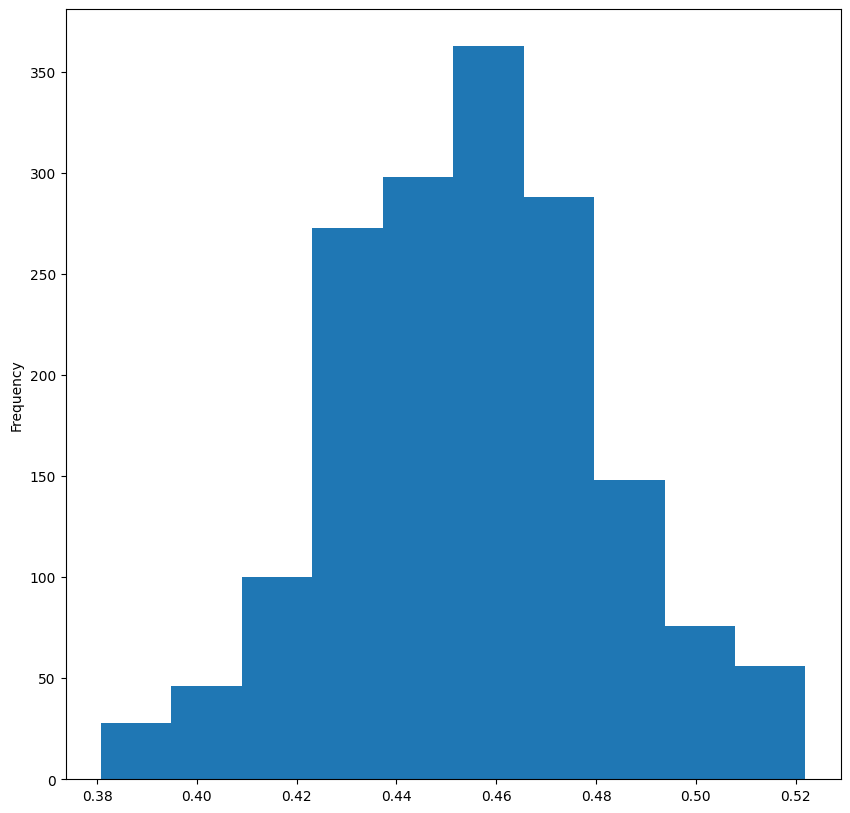

In [12]:
plt.figure(figsize=(10,10))

# 그래프의 각 노드에 대한 closeness centrality를 계산합니다.
clos_C = nx.closeness_centrality(G)

# closeness centrality 분포를 히스토그램으로 표시합니다.
closc_distr = pd.Series(clos_C)
closc_distr.plot.hist()

In [13]:
# closeness centrality의 평균을 계산합니다.
np.mean(list(clos_C.values()))

0.45484068767616925

Closeness Centrality는 또 다른 네트워크 중심성 지표로서, 네트워크 내의 모든 다른 노드까지의 평균 "거리"를 역수로 취한 값입니다. 여기서 "거리"는 두 노드 사이의 최단 경로의 길이를 의미합니다. 따라서 closeness centrality가 높은 노드는 다른 모든 노드에 가까워서 빠르게 정보나 자원을 퍼트릴 수 있는 위치에 있습니다.    

히스토그램은 closeness centrality의 분포를 보여줍니다. 특정 값 또는 범위에 얼마나 많은 노드들이 속하는지를 시각적으로 보여주어, 네트워크의 전반적인 연결 구조에 대한 이해를 돕습니다.

In [14]:
# 그래프의 degree assortativity를 계산합니다.
nx.degree_pearson_correlation_coefficient(G)

-0.13774320410491864

이 코드들은 네트워크의 통계적 속성을 분석하고 시각화하기 위한 것입니다. 이러한 속성들은 그래프의 구조와 복잡성을 이해하는 데 도움이 됩니다.   

Degree Histogram: 이 부분은 그래프의 각 노드의 degree(연결된 엣지의 수)를 계산하고, 이를 이용해 히스토그램을 그립니다. plt.yscale("log")는 y축을 로그 스케일로 설정합니다. 이렇게 하면 데이터의 왜도가 큰 경우에도 히스토그램을 더 쉽게 이해할 수 있습니다.    
 
Edge Weights Histogram: 여기서는 모든 엣지의 가중치 분포를 히스토그램으로 나타내고 있습니다. 히스토그램의 x축은 가중치, y축은 해당 가중치를 가진 엣지의 수를 나타냅니다.   

Betweenness Centrality Histogram: Betweenness centrality는 그래프 내에서 특정 노드가 얼마나 중요한지를 측정하는 지표입니다. 노드의 중요성은 다른 모든 노드 쌍 간의 최단 경로에 그 노드가 얼마나 자주 등장하는지에 기반합니다. 이 값이 높은 노드는 그래프 내에서 높은 '중개자' 역할을 하며, 정보 또는 자원이 그래프를 통해 흐르는 데 큰 영향을 미칩니다.   

Degree Centrality Histogram: Degree centrality는 노드의 degree를 기반으로 그 노드의 중요성을 측정하는 지표입니다. 각 노드의 degree centrality는 그 노드의 degree를 모든 노드의 최대 가능 degree로 나눈 값입니다.   

Closeness Centrality Histogram: Closeness centrality는 그래프 내의 노드가 다른 모든 노드에 얼마나 가까운지를 측정하는 지표입니다. 노드의 closeness centrality는 그 노드로부터 모든 다른 노드까지의 최단 경로 길이의 역수의 평균입니다.   

Assortativity: Assortativity는 그래프의 노드 간에 degree 상관관계를 측정하는 지표입니다. 양수의 assortativity 값은 degree가 비슷한 노드끼리 연결될 경향이 있음을 나타내며, 음수 값은 그 반대를 나타냅니다.   

이 코드들을 사용하여 그래프의 이러한 속성들을 분석하고, 이들이 금융 사기와 어떤 관계가 있는지 살펴볼 수 있습니다. 예를 들어, 특정 centrality 측정치가 높은 노드가 사기와 더 관련이 있는지, 또는 특정 가중치의 엣지가 사기와 더 관련이 있는지 등을 분석할 수 있습니다.

## Community Detection

먼저, 해당 코드는 Louvain 알고리즘을 사용해 그래프에서 커뮤니티(community)를 찾고, 각 커뮤니티에서 사기 사건의 비율을 계산한 후, 특정 커뮤니티의 그래프를 시각화하는 것입니다.    
 
Louvain 알고리즘은 대규모 네트워크에서 커뮤니티를 찾는 데 많이 사용되는 알고리즘으로, 모듈러리티(modularity)를 최대화하는 방식으로 동작합니다. 모듈러리티는 그래프 내에서 커뮤니티 구조를 측정하는 지표로, 높을수록 강한 커뮤니티 구조를 가진 것입니다.

In [ ]:
import community

# Louvain 알고리즘을 사용하여 그래프 G에서 커뮤니티를 찾습니다.
# 'weight' 속성을 가중치로 사용하고, random_state를 설정하여 결과의 재현성을 보장합니다.
parts = community.best_partition(G, random_state=42, weight='weight')

# parts는 노드 ID를 키로, 커뮤니티 ID를 값으로 가지는 딕셔너리입니다.
# 이를 pandas Series로 변환하여 각 커뮤니티에 속한 노드의 수를 셉니다.
communities = pd.Series(parts)
communities.value_counts().sort_values(ascending=False)

1    533
0    299
2    219
8    151
6    148
4    115
7     84
3     71
5     56
Name: count, dtype: int64

첫 번째 결과는 각 커뮤니티 ID 별로 그 커뮤니티에 속한 노드의 수를 나타냅니다. 예를 들어, 커뮤니티 4에는 417개의 노드가 있습니다.

In [16]:
# 각 커뮤니티를 서브그래프로 추출하고, 각 서브그래프에서 사기 사건의 비율을 계산합니다.
graphs = []
d = {}
for x in communities.unique():
    tmp = nx.subgraph(G, communities[communities==x].index)
    fraud_edges = sum(nx.get_edge_attributes(tmp, "label").values())
    ratio = 0 if fraud_edges == 0 else (fraud_edges/tmp.number_of_edges())*100
    d[x] = ratio
    graphs += [tmp]

# 각 커뮤니티의 사기 사건 비율을 pandas Series로 만들어서 내림차순으로 정렬합니다.
pd.Series(d).sort_values(ascending=False)

3    26.198083
5    25.641026
8    21.739130
4    19.472362
6    19.239905
7    17.294900
0     3.861272
2     1.884945
1     1.489130
dtype: float64

두 번째 결과는 각 커뮤니티 내에서 사기 사건의 비율을 나타냅니다. 예를 들어, 커뮤니티 7에서의 사기 사건 비율은 약 43.33%입니다. 이는 해당 커뮤니티의 모든 에지 중에서 사기 사건('label'이 1인 에지)의 비율을 계산한 것입니다.

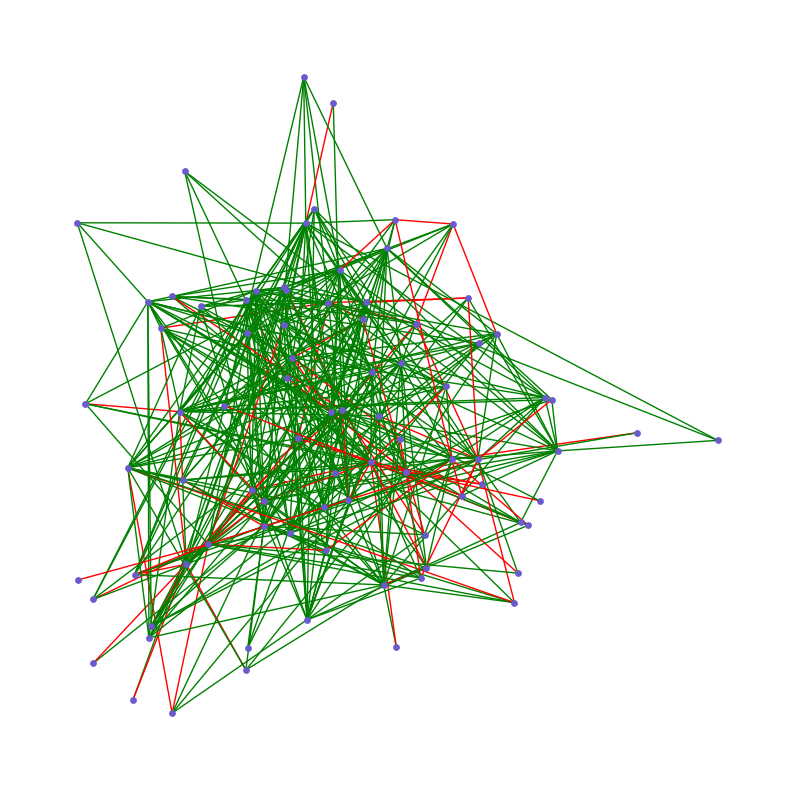

In [ ]:
# 특정 커뮤니티 (여기서는 ID가 6인 커뮤니티)의 그래프를 시각화합니다.
gId = 6
plt.figure(figsize=(10,10))
spring_pos = nx.spring_layout(graphs[gId])
plt.axis("off")
edge_colors = ["r" if x == 1 else "g" for x in nx.get_edge_attributes(graphs[gId], 'label').values()]
nx.draw_networkx(graphs[gId], pos=spring_pos, node_color=default_node_color, 
                 edge_color=edge_colors, with_labels=False, node_size=15)

마지막 부분에서는 그래프 시각화에 널리 사용되는 Fruchterman-Reingold 알고리즘(일반적으로 'spring layout'이라 불림)을 사용하여 노드의 위치를 결정합니다. 이 알고리즘은 노드를 충돌하는 입자로, 엣지를 스프링으로 간주하여 시스템의 에너지를 최소화하는 방식으로 노드의 위치를 조정합니다. 이는 그래프의 구조를 더 잘 이해할 수 있도록 도와줍니다.

그래프에서 각 요소는 다음과 같은 의미를 가집니다:     

- 보라색 점 (노드) : 이는 거래의 주체를 나타냅니다. 이 경우, 그래프에서의 노드는 신용카드 번호나 가맹점 등을 나타낼 수 있습니다.   

- 초록색 선 (에지) : 이는 거래를 나타내며, 사기 거래가 아닌 경우에는 초록색으로 표시됩니다. 즉, 두 주체간에 정상적인 거래가 발생한 것을 의미합니다.   
 
- 빨간색 선 (에지) : 이는 사기 거래를 나타냅니다. 두 주체간에 사기 거래가 발생한 것을 나타내며, 이는 빨간색으로 표시됩니다.    

그래프를 해석하는 방법은 다음과 같습니다:   

- 보라색 노드 사이의 빨간색 선 : 이는 해당 노드들 사이에서 사기 거래가 발생했다는 것을 나타냅니다. 이를 통해 어떤 주체가 사기 거래에 관련되어 있는지를 파악할 수 있습니다.    
  
- 보라색 노드 사이의 초록색 선 : 이는 해당 노드들 사이에서 정상적인 거래가 이루어졌다는 것을 나타냅니다.    

이러한 정보를 통해 사기 거래의 패턴을 분석하거나, 특정 주체가 사기 거래에 얼마나 관련되어 있는지 등을 파악할 수 있습니다. 이는 사기 거래를 탐지하고 예방하는 데에 유용한 정보를 제공합니다.   